In [1]:
import numpy as np
from PIL import Image
import os
import keras 

TUMOR_path = 'Kather_texture_2016_image_tiles_5000/01_TUMOR/'
STROMA_path = 'Kather_texture_2016_image_tiles_5000/02_STROMA/'
COMPLEX_path = 'Kather_texture_2016_image_tiles_5000/03_COMPLEX/'
LYMPHO_path = 'Kather_texture_2016_image_tiles_5000/04_LYMPHO/'
DEBRIS_path = 'Kather_texture_2016_image_tiles_5000/05_DEBRIS/'
MUCOSA_path= 'Kather_texture_2016_image_tiles_5000/06_MUCOSA/'
ADIPOSE_path = 'Kather_texture_2016_image_tiles_5000/07_ADIPOSE/'
EMPTY_path = 'Kather_texture_2016_image_tiles_5000/08_EMPTY/'

#Load the images from each folder path
TUMOR = np.array([np.array(Image.open(TUMOR_path + fname)) for fname in os.listdir(TUMOR_path)])
STROMA = np.array([np.array(Image.open(STROMA_path + fname)) for fname in os.listdir(STROMA_path)])
COMPLEX = np.array([np.array(Image.open(COMPLEX_path + fname)) for fname in os.listdir(COMPLEX_path)])
LYMPHO = np.array([np.array(Image.open(LYMPHO_path + fname)) for fname in os.listdir(LYMPHO_path)])
DEBRIS = np.array([np.array(Image.open(DEBRIS_path + fname)) for fname in os.listdir(DEBRIS_path)])
MUCOSA = np.array([np.array(Image.open(MUCOSA_path + fname)) for fname in os.listdir(MUCOSA_path)])
ADIPOSE = np.array([np.array(Image.open(ADIPOSE_path + fname)) for fname in os.listdir(ADIPOSE_path)])
EMPTY = np.array([np.array(Image.open(EMPTY_path + fname)) for fname in os.listdir(EMPTY_path)])

#Create the labels for each image so we know which image belongs to which class
TUMOR_labels = np.ones((len(TUMOR),1))
STROMA_labels = np.ones((len(STROMA),1))*2
COMPLEX_labels = np.ones((len(COMPLEX),1))*3
LYMPHO_labels = np.ones((len(LYMPHO),1))*4
DEBRIS_labels = np.ones((len(DEBRIS),1))*5
MUCOSA_labels = np.ones((len(MUCOSA),1))*6
ADIPOSE_labels = np.ones((len(ADIPOSE),1))*7
EMPTY_labels = np.ones((len(EMPTY),1))*8

In [2]:
#Combine all the images and labels into one X and y array
X = np.concatenate((TUMOR,STROMA,COMPLEX,LYMPHO,DEBRIS,MUCOSA,ADIPOSE,EMPTY),axis=0)
y = np.concatenate((TUMOR_labels,STROMA_labels,COMPLEX_labels,LYMPHO_labels,DEBRIS_labels,MUCOSA_labels,ADIPOSE_labels,EMPTY_labels),axis=0)

#Shuffle the data (prevents non random assignment to training and testing)
from sklearn.utils import shuffle
X, y = shuffle(X, y, random_state=0)

#Split the data into training and testing
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

#resize the images to 50x50 pixels and 3 channels (RGB)
from keras_preprocessing.image import img_to_array, array_to_img
X_train = np.array([img_to_array(array_to_img(im, scale=False).resize((50,50))) for im in X_train])
X_test = np.array([img_to_array(array_to_img(im, scale=False).resize((50,50))) for im in X_test])

#Normalize the data to be between 0 and 1 for same scale
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

In [3]:
#One hot encode the labels
from keras.utils import to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [4]:
from keras.preprocessing.image import ImageDataGenerator
#Create the data generator
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

In [5]:
import tensorflow as tf
#load efficientnetv2b0 model
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(
    #include_top=False so we do not include the classification layer (as it was trained with 1000 classes, not 8 like we have)
    include_top=False,
    input_tensor=None,
    input_shape=(50,50,3),
    pooling=None,
    classes=8,
    include_preprocessing=False)

#add the classification layer to the model
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
predictions = tf.keras.layers.Dense(9, activation='softmax')(x)

#this is the model we train
model = tf.keras.Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

#compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [14]:
X_train.shape

(4000, 50, 50, 3)

In [24]:
y_train.shape

(4000, 9)

In [6]:
#Train the model
history = model.fit(X_train, y_train,
                    epochs=20,
                    batch_size=32,
                    validation_data=(X_test, y_test))


Epoch 1/20
125/125 [==============================] - 39s 163ms/step - loss: 0.8341 - accuracy: 0.7030 - val_loss: 0.5779 - val_accuracy: 0.7840
Epoch 2/20
125/125 [==============================] - 15s 124ms/step - loss: 0.5887 - accuracy: 0.7887 - val_loss: 0.4809 - val_accuracy: 0.8260
Epoch 3/20
125/125 [==============================] - 16s 129ms/step - loss: 0.5088 - accuracy: 0.8125 - val_loss: 0.4716 - val_accuracy: 0.8360
Epoch 4/20
125/125 [==============================] - 16s 125ms/step - loss: 0.4974 - accuracy: 0.8260 - val_loss: 0.5363 - val_accuracy: 0.8060
Epoch 5/20
125/125 [==============================] - 16s 124ms/step - loss: 0.4704 - accuracy: 0.8313 - val_loss: 0.4351 - val_accuracy: 0.8320
Epoch 6/20
125/125 [==============================] - 16s 126ms/step - loss: 0.4181 - accuracy: 0.8508 - val_loss: 0.4374 - val_accuracy: 0.8410
Epoch 7/20
125/125 [==============================] - 17s 138ms/step - loss: 0.4155 - accuracy: 0.8530 - val_loss: 0.4621 - val_ac

In [34]:
#save the model
model.save('model_efficientnetv2b0.h5')

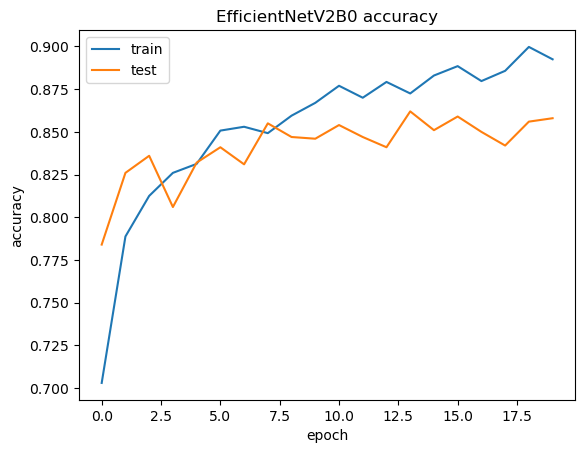

In [8]:
#plot the training and validation accuracy for each epoch, overlaying the training and validation accuracy for each epoch with 2 different colors

import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('EfficientNetV2B0 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()




In [9]:
#use model on test data
y_pred = model.predict(X_test)

32/32 [==============================] - 8s 112ms/step


In [10]:
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test, axis=1)

Text(95.72222222222221, 0.5, 'Truth')

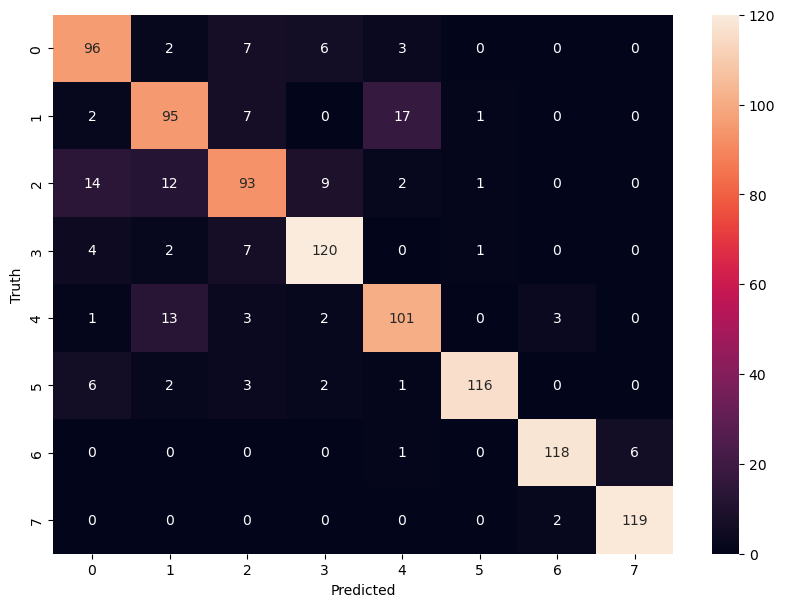

In [11]:
#create a confusion matrix to see how well the model performed on the test data
import matplotlib.pyplot as plt
#Create the confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

#plot confusion matrix cm
import seaborn as sns
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Truth')



In [ ]:
#accuracy metrics on test data
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Precision: ', precision_score(y_test, y_pred, average='weighted'))
